# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import deepcell

### Load the Training Data

In [2]:
# create folder for this set of experiments
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [17]:
npz_name = "Decidua_Shirley_Relabel_Train_256x256_HLAG_Swap"
training_data = np.load(NPZ_DIR + npz_name +".npz")
(X_train, y_train) = training_data["X"], training_data["y"]

print('X_train.shape: {}\ny_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (441, 256, 256, 3)
y_train.shape: (441, 256, 256, 1)


### Set up filepath constants

In [18]:
# the path to the data file is currently required for `train_model_()` functions
DATA_FILE = os.path.join(NPZ_DIR, npz_name + ".npz")

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

### Set up training parameters

In [19]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = npz_name + '_convolutional_watershed_101_rf_256_dense_64_conv'

n_epoch = 10  # Number of training epochs
norm_method = 'std'  # data normalization
receptive_field = 101  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)
test_size = 0.05
seed = 0
# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 2  # erode edges, improves segmentation when cells are close

### Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [20]:
from deepcell import model_zoo

watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=64,
    n_dense_filters=256,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

#### Train the distance transform model

In [21]:
from deepcell.training import train_model_conv

watershed_model = train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    seed=seed,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (418, 256, 256, 3)
y_train shape: (418, 256, 256, 1)
X_test shape: (23, 256, 256, 3)
y_test shape: (23, 256, 256, 1)
Output Shape: (None, 256, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/10
417/418 [============================>.] - ETA: 0s - loss: 4.6758 - model_10_loss: 1.1426 - model_11_loss: 1.1472 - model_12_loss: 1.1459 - model_13_loss: 1.1578 - model_10_acc: 0.5949 - model_11_acc: 0.5982 - model_12_acc: 0.5985 - model_13_acc: 0.5927
Epoch 00001: val_loss improved from inf to 11.15710, saving model to /data/models/20191113_Decidua_Shirley_Relabel/Decidua_Shirley_Relabel_Train_256x256_HLAG_Swap_convolutional_watershed_101_rf_256_dense_64_conv.h5
418/418 [==============================] - 135s 322ms/step - loss: 4.6772 - model_10_loss: 1.1432 - model_11_loss: 1.1479 - model_12_loss: 1.1460 - model_13_loss: 1.1578 - model_10_acc: 0.5948 - model_11_acc: 0.5982 - model_12_acc: 0.5985 - model_13_acc: 0.5927 - val_loss: 11.1571 - val_model_10_loss: 2.4157 - va

Epoch 10/10
417/418 [============================>.] - ETA: 0s - loss: 3.7008 - model_10_loss: 0.9215 - model_11_loss: 0.9015 - model_12_loss: 0.9005 - model_13_loss: 0.8940 - model_10_acc: 0.7007 - model_11_acc: 0.7108 - model_12_acc: 0.7121 - model_13_acc: 0.7145
Epoch 00010: val_loss did not improve from 3.76704
418/418 [==============================] - 116s 278ms/step - loss: 3.7000 - model_10_loss: 0.9213 - model_11_loss: 0.9013 - model_12_loss: 0.9003 - model_13_loss: 0.8938 - model_10_acc: 0.7007 - model_11_acc: 0.7108 - model_12_acc: 0.7121 - model_13_acc: 0.7145 - val_loss: 3.7918 - val_model_10_loss: 0.9352 - val_model_11_loss: 0.9140 - val_model_12_loss: 0.9255 - val_model_13_loss: 0.9339 - val_model_10_acc: 0.7437 - val_model_11_acc: 0.7597 - val_model_12_acc: 0.7591 - val_model_13_acc: 0.7544


### Run the model

In [8]:
test_data = np.load(NPZ_DIR + "Decidua_Shirley_Relabel_Test.npz")
(X_test, y_test) = test_data["X"], test_data["y"]

In [22]:
weights_path = os.path.join(MODEL_DIR, conv_model_name + ".h5")
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=64,
    n_dense_filters=256,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]))

run_conv_model.load_weights(weights_path)

In [23]:
# make predictions on testing data
test_images = run_conv_model.predict(X_test[:1])[-1]

print('watershed transform shape:', test_images.shape)

watershed transform shape: (1, 1024, 1024, 4)


### Watershed post-processing

In [24]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 1024, 1024, 1)


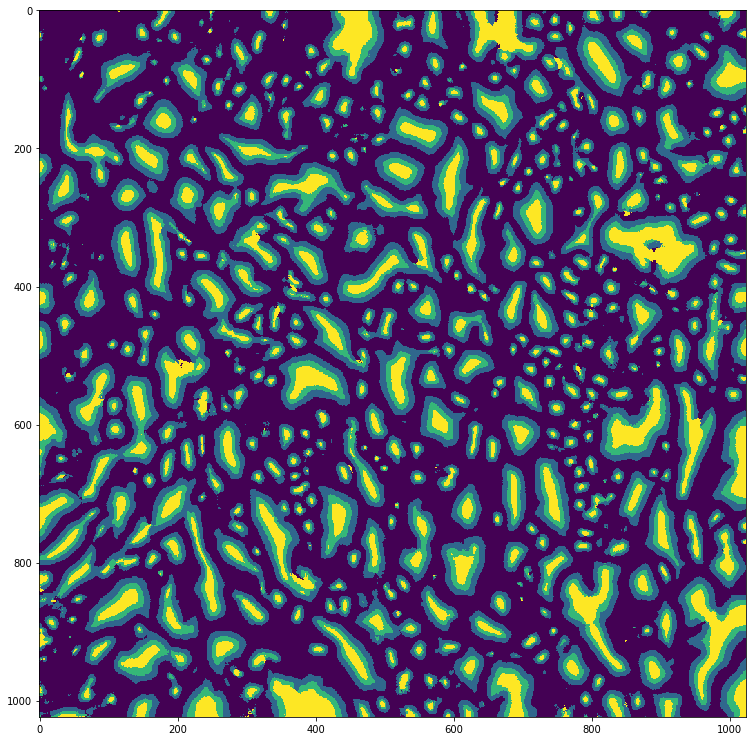

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])

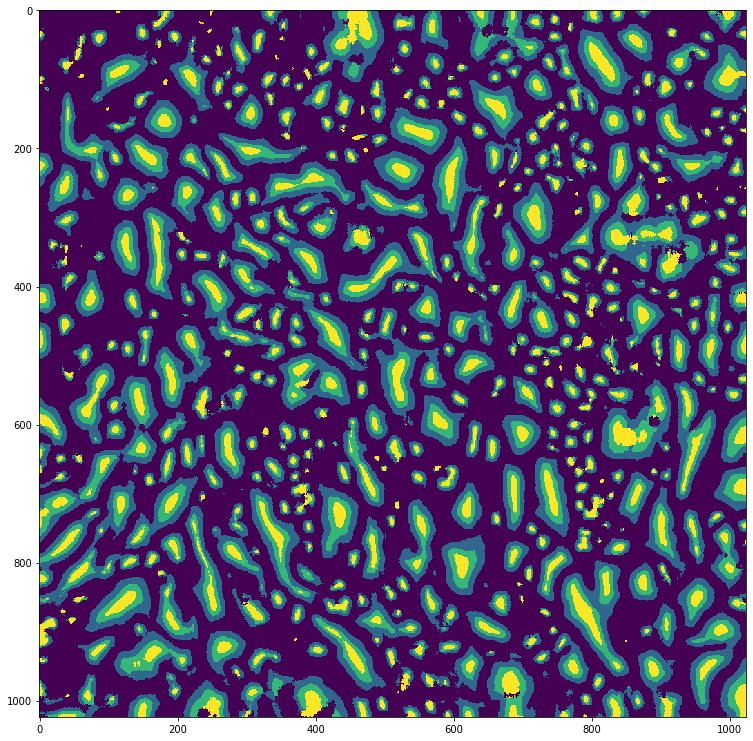

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])

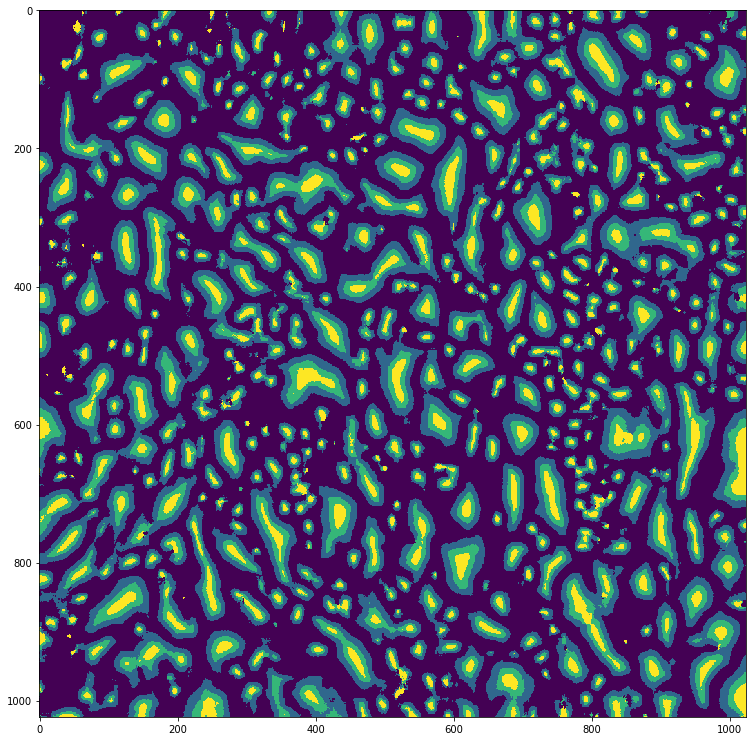

In [25]:
#
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])









































